In [1]:
import sys
import os

# Go one level up from notebooks/ to project root
sys.path.append(os.path.abspath(".."))

from src.data_loader import load_data_from_mongo
from src.preprocessing import clean_retail_data
import pandas as pd

# Load & clean data
df = load_data_from_mongo()
df_clean = clean_retail_data(df)

# Reference date (1 day after last purchase)
reference_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

reference_date

Data successfully loaded from MongoDB.
Shape: (541909, 8)
Data cleaning completed.
Cleaned data shape: (397924, 9)


Timestamp('2011-12-10 12:50:00')

In [2]:
rfm = df_clean.groupby('CustomerID').agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,
    "InvoiceNo": 'nunique',
    "TotalAmount": 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40


In [3]:
rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,15299.936852,92.518322,4.271952,2053.793018
std,1721.889758,100.009747,7.705493,8988.248381
min,12346.000000,1.000000,1.000000,0.000000
25%,13812.500000,18.000000,1.000000,307.245000
50%,15299.000000,51.000000,2.000000,674.450000
75%,16778.500000,142.000000,5.000000,1661.640000
max,18287.000000,374.000000,210.000000,280206.020000


In [4]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = rfm['Monetary'].quantile(0.25)
Q3 = rfm['Monetary'].quantile(0.75)

# Inter Quartile Range (IQR)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = rfm[
    (rfm['Monetary'] > upper_bound) | 
    (rfm['Monetary'] < lower_bound)
]

outliers

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
10,12357,33,1,6207.67
12,12359,58,4,6372.58
15,12362,3,10,5226.23
...,...,...,...,...
4292,18223,5,14,6484.54
4294,18225,3,12,5509.12
4295,18226,44,11,5228.05
4298,18229,12,20,7276.90


In [5]:
import numpy as np

rfm_log = rfm.copy()

rfm_log["Recency"] = np.log1p(rfm_log["Recency"])
rfm_log["Frequency"] = np.log1p(rfm_log["Frequency"])
rfm_log["Monetary"] = np.log1p(rfm_log["Monetary"])

rfm_log.describe()

,CustomerID,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,15299.936852,3.830475,1.345478,6.592108
std,1721.889758,1.340215,0.683138,1.261411
min,12346.000000,0.693147,0.693147,0.000000
25%,13812.500000,2.944439,0.693147,5.730895
50%,15299.000000,3.951244,1.098612,6.515379
75%,16778.500000,4.962845,1.791759,7.416162
max,18287.000000,5.926926,5.351858,12.543284


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(
    rfm_log[["Recency", "Frequency", "Monetary"]]
)

rfm_scaled[:5]

array([[ 1.46223615, -0.95501313,  3.69616759],
       [-2.03861142,  1.07452296,  1.40875812],
       [ 0.37331015,  0.38643726,  0.71551656],
       [-0.62291426, -0.95501313,  0.69782099],
       [ 1.42479959, -0.95501313, -0.61587654]])

In [7]:
rfm_log.describe()

,CustomerID,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,15299.936852,3.830475,1.345478,6.592108
std,1721.889758,1.340215,0.683138,1.261411
min,12346.000000,0.693147,0.693147,0.000000
25%,13812.500000,2.944439,0.693147,5.730895
50%,15299.000000,3.951244,1.098612,6.515379
75%,16778.500000,4.962845,1.791759,7.416162
max,18287.000000,5.926926,5.351858,12.543284


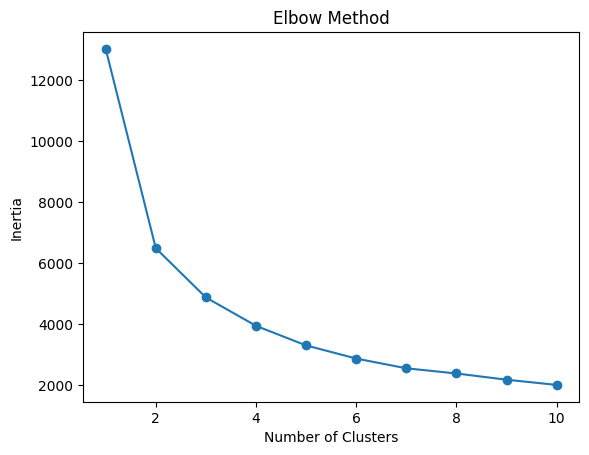

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure()
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [9]:
from kneed import KneeLocator

knee = KneeLocator(K_range, inertia, curve='convex', direction='decreasing')

print("Optimal K (KneeLocator):", knee.knee)

Optimal K (KneeLocator): 3


In [10]:
from sklearn.metrics import silhouette_score

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f"Silhouette Score for k={k}: {score}")

Silhouette Score for k=2: 0.43296991873369034
Silhouette Score for k=3: 0.3356121569034344
Silhouette Score for k=4: 0.33627437675322647
Silhouette Score for k=5: 0.3160812218640858
Silhouette Score for k=6: 0.3053143353328171
Silhouette Score for k=7: 0.3092732145696885


In [11]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)

rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346,326,1,77183.60,2
1,12347,2,7,4310.00,1
2,12348,75,4,1797.24,2
3,12349,19,1,1757.55,0
4,12350,310,1,334.40,3


In [12]:
cluster_summary = rfm.groupby("Cluster").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean",
    "CustomerID": "count"
}).rename(columns={"CustomerID": "Count"})

cluster_summary

,Recency,Frequency,Monetary,Count
Cluster,,,,
0,18.725864,2.090584,538.231287,839
1,12.112033,13.634855,8015.424412,723
2,70.697380,4.076923,1791.090873,1183
3,184.023839,1.318068,342.421268,1594


In [13]:
rfm['Cluster'].value_counts(normalize=True) * 100

Cluster
3    36.736575
2    27.264347
0    19.336253
1    16.662826
Name: proportion, dtype: float64

In [14]:
cluster_mapping = {
    0: "Active Regular",
    1: "VIP Loyal",
    2: "At Risk",
    3: "Lost Customers"
}

rfm['Cluster'] = rfm['Cluster'].map(cluster_mapping)

In [15]:
from sklearn.metrics import silhouette_score

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f"K={k}, Silhouette Score={score:.4f}")

K=2, Silhouette Score=0.4330
K=3, Silhouette Score=0.3356
K=4, Silhouette Score=0.3363
K=5, Silhouette Score=0.3161
K=6, Silhouette Score=0.3053
K=7, Silhouette Score=0.3093


In [16]:
rfm["Churn"] = rfm["Recency"].apply(lambda x: 1 if x > 90 else 0)

In [17]:
rfm["Churn"].value_counts(normalize=True)

Churn
0    0.666052
1    0.333948
Name: proportion, dtype: float64

In [18]:
# Average Order Value (AOV) = Total Revenue / Number of Orders
rfm["AvgOrderValue"] = rfm["Monetary"] / rfm["Frequency"]

In [26]:
# Purchase Velocity = Number of Orders / Customer Lifetime (in days)
# rfm["CustomerLifetimeDays"] = 373 - rfm["Recency"]

# rfm["PurchaseRate"] = rfm["Frequency"] / (rfm["CustomerLifetimeDays"] + 1)


customer_dates = df_clean.groupby("CustomerID").agg({
    "InvoiceDate": ["min", "max"]
})

customer_dates.columns = ["FirstPurchase", "LastPurchase"]
customer_dates = customer_dates.reset_index()

customer_dates["CustomerLifetimeDays"] = (
    customer_dates["LastPurchase"] - customer_dates["FirstPurchase"]
).dt.days

In [27]:
# Revenue Intensity = Total Revenue / Customer Lifetime (in days)
# rfm["MonetaryPerDay"] = rfm["Monetary"] / (rfm["CustomerLifetimeDays"] + 1)

rfm = rfm.merge(
    customer_dates[["CustomerID", "CustomerLifetimeDays"]],
    on="CustomerID",
    how="left"
)

In [28]:
rfm.replace([np.inf, -np.inf], np.nan, inplace=True)
rfm.dropna(inplace=True)

In [29]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster,Churn,AvgOrderValue,CustomerLifetimeDays_x,PurchaseRate,MonetaryPerDay,CustomerLifetimeDays_y
0,12346,326,1,77183.60,At Risk,1,77183.600000,47,0.020833,1607.991667,0
1,12347,2,7,4310.00,VIP Loyal,0,615.714286,371,0.018817,11.586022,365
2,12348,75,4,1797.24,At Risk,0,449.310000,298,0.013378,6.010836,282
3,12349,19,1,1757.55,Active Regular,0,1757.550000,354,0.002817,4.950845,0
4,12350,310,1,334.40,Lost Customers,1,334.400000,63,0.015625,5.225000,0


In [59]:
# Create feature matrix X and target vector y for churn prediction
X = rfm[
    [
        #"Recency",
        "Frequency",
        "Monetary",
        "AvgOrderValue",
        #"PurchaseRate",
        #"MonetaryPerDay"
    ]
]

y = rfm["Churn"]

In [60]:
# Scale features
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [62]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [63]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=42)

model.fit(X_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [64]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

In [65]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80       566
           1       0.63      0.62      0.62       301

    accuracy                           0.74       867
   macro avg       0.71      0.71      0.71       867
weighted avg       0.74      0.74      0.74       867



In [66]:
# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.7732880973903243


In [67]:
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[456 110]
 [115 186]]


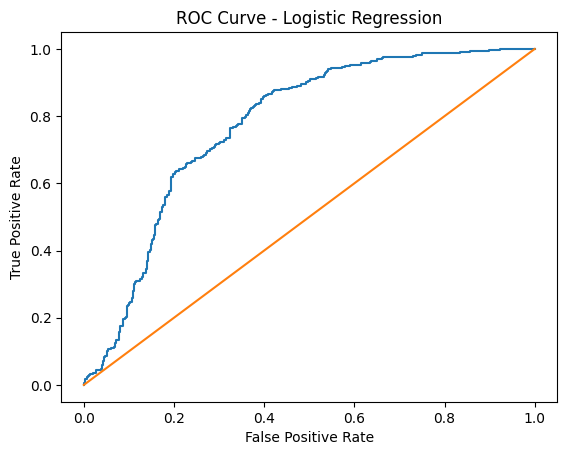

In [68]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.show()

In [69]:
# Change threshold
threshold = 0.35

y_pred_custom = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.87      0.63      0.73       566
           1       0.54      0.82      0.65       301

    accuracy                           0.70       867
   macro avg       0.71      0.73      0.69       867
weighted avg       0.76      0.70      0.70       867



In [70]:
# Feature importance for Logistic Regression
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

feature_importance

,Feature,Coefficient
2,AvgOrderValue,0.113807
1,Monetary,-0.402782
0,Frequency,-3.291188


In [71]:
# Churn probability for each customer
rfm["Churn_Probability"] = model.predict_proba(
    scaler.transform(X)
)[:,1]

rfm.groupby("Cluster")["Churn_Probability"].mean()

Cluster
Active Regular    0.406013
At Risk           0.245242
Lost Customers    0.481967
VIP Loyal         0.047407
Name: Churn_Probability, dtype: float64

In [72]:
# Training XGBoost Classifier
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("Classification Report - XGBoost")
print(classification_report(y_test, y_pred_xgb))

print("ROC-AUC Score - XGBoost:", roc_auc_score(y_test, y_proba_xgb))

Classification Report - XGBoost
              precision    recall  f1-score   support

           0       0.74      0.84      0.79       566
           1       0.60      0.45      0.51       301

    accuracy                           0.71       867
   macro avg       0.67      0.64      0.65       867
weighted avg       0.69      0.71      0.69       867

ROC-AUC Score - XGBoost: 0.7725749269220384


c:\Users\abhik\Downloads\ds_projects\customer-segmentation-retention\venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [14:11:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [73]:
# Feature importance for XGBoost

importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

importance

,Feature,Importance
0,Frequency,0.615636
1,Monetary,0.218339
2,AvgOrderValue,0.166025


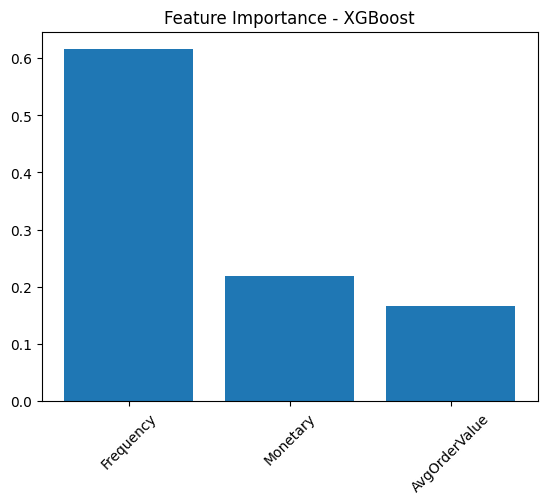

In [74]:
plt.figure()
plt.bar(importance["Feature"], importance["Importance"])
plt.xticks(rotation=45)
plt.title("Feature Importance - XGBoost")
plt.show()

In [75]:
threshold = 0.35
y_pred_custom_xgb = (y_proba_xgb >= threshold).astype(int)

print(classification_report(y_test, y_pred_custom_xgb))

              precision    recall  f1-score   support

           0       0.84      0.67      0.75       566
           1       0.55      0.75      0.63       301

    accuracy                           0.70       867
   macro avg       0.69      0.71      0.69       867
weighted avg       0.74      0.70      0.71       867



In [ ]:
'''import os
import joblib

MODEL_PATH = os.path.join("..", "models")
os.makedirs(MODEL_PATH, exist_ok=True)

joblib.dump(model, os.path.join(MODEL_PATH, "logistic_model.pkl"))
joblib.dump(scaler, os.path.join(MODEL_PATH, "scaler.pkl"))'''

['..\\models\\scaler.pkl']